# MEV Capture Distribution Modeling – Full Pipeline

### Project Goal  
To understand and compare how different Ethereum builders capture MEV (Maximal Extractable Value), by modeling their MEV-per-block distributions and using those models for simulation and analysis.

### 1. Data Collection

- Source from BigQuery Public Datasets: Ethereum blocks, transactions, traces, and builder payloads
- Method:
    - SQL queries combine block data with MEV-relevant fields  
    - Only blocks with non-zero MEV captured are included

⚠️ To access BigQuery datasets, please run the following command **in your terminal**:

    gcloud auth application-default login
Then return here and run the code below.

In [300]:
# The code below checks for required Python packages
required_packages = [
    "google-cloud-bigquery", "db-dtypes", "pandas", "numpy", "matplotlib", "seaborn", "scipy"
]

import importlib, subprocess, sys, pkg_resources
for pkg in required_packages:
    try:
        importlib.import_module(pkg.split("==")[0])
    except ImportError:
        print(f"Installing missing package: {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

# Standard imports
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import lognorm, pareto, kstest
import warnings
warnings.filterwarnings("ignore")

Installing missing package: google-cloud-bigquery …


python(93430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Installing missing package: db-dtypes …


python(93432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [301]:
# Authenticate if in Colab
# from google.colab import auth
# auth.authenticate_user()

# Set up BigQuery client
client = bigquery.Client(project="camcos-458721")

# Test query: list a few datasets from the public project
for dataset in client.list_datasets("bigquery-public-data"):
    print("Available dataset:", dataset.dataset_id)

python(93433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Available dataset: america_health_rankings
Available dataset: austin_311
Available dataset: austin_bikeshare
Available dataset: austin_crime
Available dataset: austin_incidents
Available dataset: austin_waste
Available dataset: baseball
Available dataset: bbc_news
Available dataset: bigqueryml_ncaa
Available dataset: bitcoin_blockchain
Available dataset: blackhole_database
Available dataset: blockchain_analytics_ethereum_mainnet_us
Available dataset: bls
Available dataset: bls_qcew
Available dataset: breathe
Available dataset: broadstreet_adi
Available dataset: catalonian_mobile_coverage
Available dataset: catalonian_mobile_coverage_eu
Available dataset: census_bureau_acs
Available dataset: census_bureau_construction
Available dataset: census_bureau_international
Available dataset: census_bureau_usa
Available dataset: census_opportunity_atlas
Available dataset: census_utility
Available dataset: cfpb_complaints
Available dataset: chicago_crime
Available dataset: chicago_taxi_trips
Avail

Note: We define `mev_captured_eth` in this notebook as the **gross MEV extracted** by builders,
i.e., the sum of priority fees and direct coinbase transfers. This does not subtract bid payments to validators.


In [ ]:
# SQL query to extract MEV capture data from Ethereum blocks
# Change the date window to your desired period (defult: DATE("2023-12-01") AND DATE("2024-02-01"))
# This query calculates the miner rewards from priority fees and aggregates MEV capture data

query = f"""
-- Step 1: Calculate miner rewards per block from priority fees (effective_gas_price - base_fee) * gas_used

WITH breward AS (
  SELECT
    t.block_number,
    SUM(
      (CAST(t.receipt_effective_gas_price AS BIGNUMERIC) - CAST(b.base_fee_per_gas AS BIGNUMERIC))
      * CAST(t.receipt_gas_used AS BIGNUMERIC)
    ) AS minerRewards
  FROM `bigquery-public-data.crypto_ethereum.transactions` t
  JOIN `bigquery-public-data.crypto_ethereum.blocks` b
    ON t.block_number = b.number
  WHERE t.receipt_status = 1  -- Only consider successful transactions
  GROUP BY t.block_number     -- Aggregate to block level
),

-- Step 2: Aggregate block-level MEV capture: includes miner rewards and ETH sent to builders

block_mev AS (
  SELECT
    b.number AS block_number,
    b.timestamp AS block_timestamp,
    p.builder_pubkey,
    
    -- Prefer known tag name; fallback to decoded extra_data
    COALESCE(
      tags.tag,
      SAFE_CONVERT_BYTES_TO_STRING(FROM_HEX(SUBSTR(b.extra_data, 3)))
    ) AS builder_name,

    breward.minerRewards,

    -- Sum of ETH sent to builder, often transferred to the block proposer (coinbase address)
    SUM(tobuilder.value) AS sentToBuilder

  FROM `bigquery-public-data.crypto_ethereum.blocks` b
  JOIN `eden-data-public.mev_boost.payloads` p
    ON b.number = p.block_number AND b.timestamp = p.block_timestamp  -- Match payloads with blocks
  LEFT JOIN `eden-data-public.ethereum_auxiliary.tags_pubkey` tags
    ON p.builder_pubkey = tags.pubkey  -- Match builder to known labels
  LEFT JOIN breward
    ON breward.block_number = b.number
  LEFT JOIN (

    -- From traces, find successful transactions sent to the block proposer
    SELECT block_number, value, to_address
    FROM `bigquery-public-data.crypto_ethereum.traces`
    WHERE status = 1
  ) tobuilder
    ON tobuilder.block_number = b.number
    AND LOWER(tobuilder.to_address) = LOWER(b.miner)  -- Focus on ETH sent to coinbase
---------------------------------------------------------------------------------------------------
  WHERE DATE(b.timestamp) BETWEEN DATE("2023-12-01") AND DATE("2024-02-01")  -- Time window
---------------------------------------------------------------------------------------------------

  -- builder_name must be included in GROUP BY because it's not an aggregate
  GROUP BY block_number, block_timestamp, p.builder_pubkey, builder_name, minerRewards
)

-- Step 3: Extract final MEV capture data per builder per block

SELECT
  block_number,
  block_timestamp,
  builder_name,
  
  -- Actual ETH captured by builder (priority fee + ETH sent to proposer)
  (COALESCE(minerRewards, 0) + COALESCE(sentToBuilder, 0)) / 1e18 AS mev_captured_eth

FROM block_mev
WHERE (COALESCE(minerRewards, 0) + COALESCE(sentToBuilder, 0)) > 0  -- Exclude blocks with zero MEV capture
ORDER BY block_number;
"""

In [303]:
# Execute the query and convert the results to a DataFrame

df = client.query(query).to_dataframe()
# df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])
df.head()

,block_number,block_timestamp,builder_name,mev_captured_eth
0,18687851,2023-12-01 00:00:11+00:00,builder0x69,0.25846155676771270600000000000000000000
1,18687852,2023-12-01 00:00:23+00:00,Flashbots,4.47975951383673205600000000000000000000
2,18687853,2023-12-01 00:00:35+00:00,rsync-builder,0.98187261982080141200000000000000000000
3,18687854,2023-12-01 00:00:47+00:00,rsync-builder,0.12738168095302177900000000000000000000
4,18687855,2023-12-01 00:00:59+00:00,rsync-builder,0.08133671367043397100000000000000000000


### 2. Data Preparation & Cleaning

#### Steps
- Remove duplicates (`block_number`)
- Convert `mev_captured_eth` to float
- Filter out invalid or zero MEV values
- Create a core dataset: keep only the ≤ 99th percentile of MEV values for stable modeling
- Output: a clean dataset `df_q99` ready for analysis


In [ ]:
# -------------------------------------------------
# Check dataset
# -------------------------------------------------
# Time window & raw sanity checks
start_time = df['block_timestamp'].min()
end_time   = df['block_timestamp'].max()

print(f"start time: {start_time}")
print(f"end time:   {end_time}")

# How many rows are identical duplicates?
print("Duplicated rows  :", df.duplicated().sum())

# Column-level missing values
print("Null values per column:\n", df.isnull().sum())

# Basic dtypes / memory footprint
print(df.info())

start time: 2023-12-01 00:00:11+00:00
end time:   2024-02-01 23:59:47+00:00
Duplicated rows  : 7480
Null values per column:
 block_number        0
block_timestamp     0
builder_name        0
mev_captured_eth    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419663 entries, 0 to 419662
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   block_number      419663 non-null  Int64              
 1   block_timestamp   419663 non-null  datetime64[us, UTC]
 2   builder_name      419663 non-null  object             
 3   mev_captured_eth  419663 non-null  object             
dtypes: Int64(1), datetime64[us, UTC](1), object(2)
memory usage: 13.2+ MB
None


In [309]:
# -------------------------------------------------
# Data cleaning
# -------------------------------------------------
# Ensure MEV column is numeric (errors → NaN, handled later)
df['mev_captured_eth'] = pd.to_numeric(df['mev_captured_eth'], errors='coerce')

# Normalize builder name
df["builder_name"] = df["builder_name"].str.lower()

# Remove duplicates
df_clean = df.drop_duplicates()

print("Duplicated rows after cleanup:", df_clean.duplicated().sum())

# Quick descriptive statistics of the clean MEV series
mev = df_clean['mev_captured_eth']
print(mev.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

Duplicated rows after cleanup: 0
count    412183.000000
mean          0.171430
std           3.353621
min           0.000894
25%           0.030827
50%           0.054210
75%           0.104139
90%           0.211412
95%           0.357261
99%           1.478971
max        1208.076907
Name: mev_captured_eth, dtype: float64


## 3. Overall Builder MEV Analysis

To understand how MEV is distributed across all builders and assess overall trends.

#### Process
- Visualize the full distribution of MEV (log-log plots)
- Fit a log-normal distribution to all blocks
- Decide on trimming strategy (cut above 99% due to visible outliers)
- Final distribution stats: mean, standard deviation

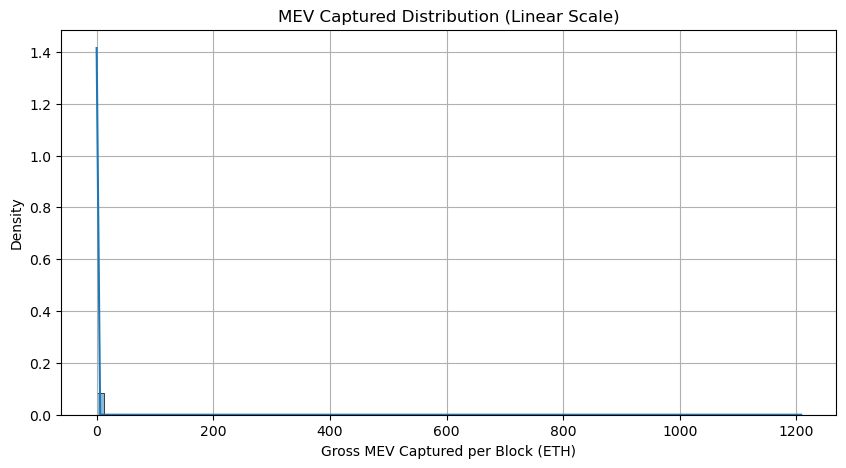

In [310]:
# Histogram on full data (linear scale)
plt.figure(figsize=(10, 5))
sns.histplot(mev, bins=100, stat="density", kde=True)  # KDE gives a smooth curve
plt.xlabel("Gross MEV Captured per Block (ETH)")
plt.ylabel("Density")
plt.title("MEV Captured Distribution (Linear Scale)")
plt.grid(True)
plt.show()

MEV description and the plot shows extreme right skew. Almost all MEV values are clustered close to zero, and a very small number of outliers stretch all the way out to 1200 ETH per block.

Try to trim 99 % cutoffof the histogram to better see the core body of the distribution.

Blocks kept (≤ 99th pct): 408061 of 412183


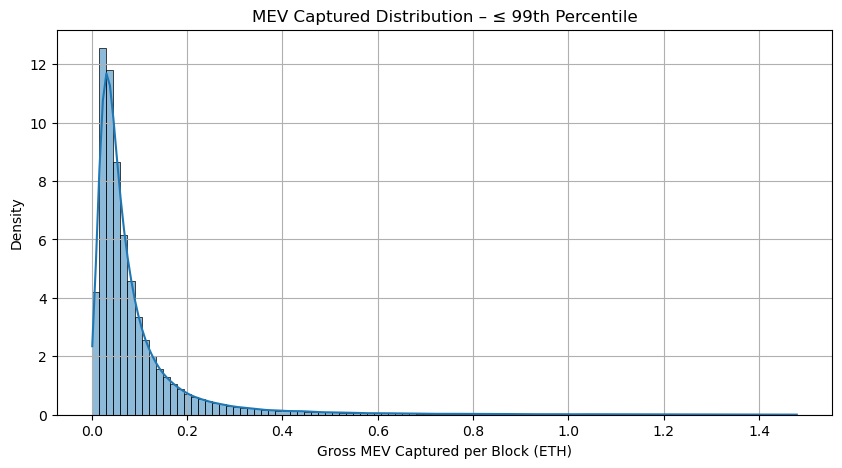

In [311]:
# -------------------------------------------------
# Trim values above the 99th percentile
# -------------------------------------------------
df_q99 = df_clean[mev <= mev.quantile(0.99)]          # keep ≤ 99 % threshold
print("Blocks kept (≤ 99th pct):", len(df_q99), "of", len(df_clean))

plt.figure(figsize=(10, 5))
sns.histplot(df_q99['mev_captured_eth'], bins=100, stat="density", kde=True)
plt.xlabel("Gross MEV Captured per Block (ETH)")
plt.ylabel("Density")
plt.title("MEV Captured Distribution – ≤ 99th Percentile")
plt.grid(True)
plt.show()

Single peak between 0.02–0.05 ETH, then a long decay — classic shape of: Gamma or LogNormal distribution.

decide on a fitting family:

– If the trimmed distribution looks log-normal, fit log-normal. 
LogNormal models log(x) ~ N(μ, σ), also fits heavy-tailed data well

– If still heavy-tail, maybe fit Pareto or log-logistic

Optionally keep two models: one for core (≤99 %), one for tail (>99 %).

Log-normal fit parameters (≤99% MEV):
  shape = 0.9341
  loc   = 0.0000
  scale = 0.0581


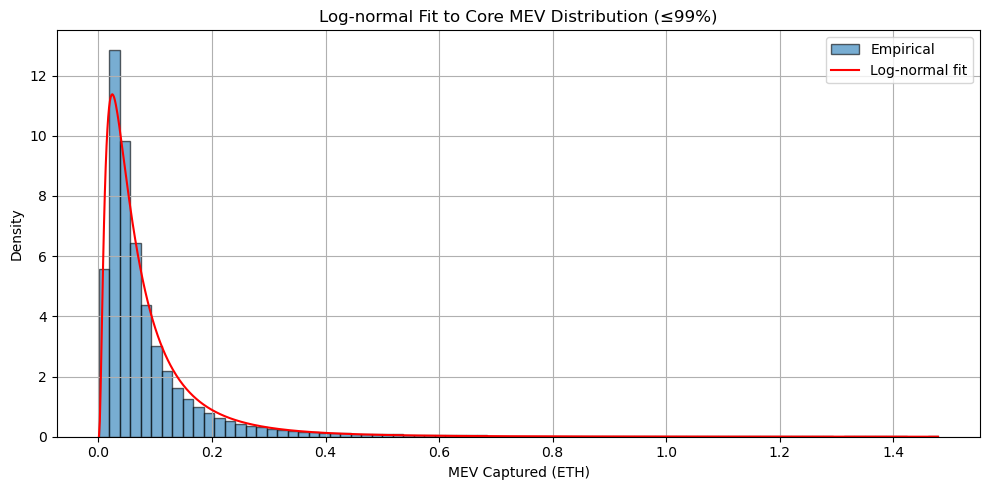

In [312]:
# -------------------------------
# Fit a log-normal distribution
# -------------------------------
# Extract MEV values under 99th percentile
core_mev = df_q99["mev_captured_eth"]

# Fit log-normal (fix loc=0 for stability)
shape, loc, scale = lognorm.fit(core_mev, floc=0)

print(f"Log-normal fit parameters (≤99% MEV):")
print(f"  shape = {shape:.4f}")
print(f"  loc   = {loc:.4f}")
print(f"  scale = {scale:.4f}")

# Plot histogram + PDF
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(core_mev, bins=80, density=True, alpha=0.6, edgecolor='black', label="Empirical")
x = np.linspace(core_mev.min(), core_mev.max(), 1000)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r-', label="Log-normal fit")
plt.xlabel("MEV Captured (ETH)")
plt.ylabel("Density")
plt.title("Log-normal Fit to Core MEV Distribution (≤99%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The red log-normal curve fits the histogram well, especially the bulk between 0–0.2 ETH.

Slight deviations at the very low end (<0.01) and high tail (~1.0+) are expected and acceptable in trimmed data.

In [313]:
# -------------------------------------------------
# # Perform the KS test on the core data
# -------------------------------------------------

# The KS test compares the empirical distribution of the data with the fitted log-normal distribution
# The KS test statistic is the maximum distance between the empirical CDF and the fitted CDF (small representing a closer distribution)

# The fitted log-normal distribution is defined by the parameters shape, loc, and scale
ks_stat, ks_p = kstest(core_mev, lambda x: lognorm.cdf(x, shape, loc, scale))

print(f"Kolmogorov–Smirnov test result:")
print(f"  KS statistic = {ks_stat:.4f}")
print(f"  p-value      = {ks_p:.4e}")

Kolmogorov–Smirnov test result:
  KS statistic = 0.0362
  p-value      = 0.0000e+00


Although the p-value is technically zero, the KS statistic of 0.0362 is very low, indicating a strong match between the fitted log-normal and the actual MEV values (up to the 99th percentile). So the log-normal fitted model of MEV capture in all builders level is a solid match .

In [314]:
print("✔️ Log-normal parameters for core MEV (≤ 99th percentile):")
print(f"  shape (σ) = {shape:.4f}")
print(f"  loc       = {loc:.4f}   # fixed at 0")
print(f"  scale     = {scale:.4f}")

# convert to log-space parameters
log_std = shape
log_mean = np.log(scale)

print(f"log-space mean (μ) = {log_mean:.4f}")
print(f"log-space std  (σ) = {log_std:.4f}")

# Optional: show mean and std of the distribution
mean = lognorm.mean(shape, loc=loc, scale=scale)
std  = lognorm.std(shape, loc=loc, scale=scale)
print(f"\n  Distribution mean ≈ {mean:.4f} ETH")
print(f"  Distribution std  ≈ {std:.4f} ETH")


✔️ Log-normal parameters for core MEV (≤ 99th percentile):
  shape (σ) = 0.9341
  loc       = 0.0000   # fixed at 0
  scale     = 0.0581
log-space mean (μ) = -2.8462
log-space std  (σ) = 0.9341

  Distribution mean ≈ 0.0898 ETH
  Distribution std  ≈ 0.1060 ETH


This corresponds to a mean of ≈ 0.0898 ETH and standard deviation ≈ 0.1060 ETH,
indicating that most typical blocks have MEV around 0.09 ETH with moderate variability.


## 4. Builder-Specific Modeling

In [315]:
# Select two target builders
target_builders = ["bobthebuilder", "beaverbuild.org"]
df_filtered = df_q99[df_q99["builder_name"].isin(target_builders)]

# Print count per builder
print("Block counts per builder:")
print(df_filtered["builder_name"].value_counts())

# Show MEV description stats per builder
print("\nMEV descriptive stats per builder:")
print(df_filtered.groupby("builder_name")["mev_captured_eth"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


Block counts per builder:
builder_name
beaverbuild.org    130396
bobthebuilder         169
Name: count, dtype: int64

MEV descriptive stats per builder:
                    count      mean       std       min       25%       50%  \
builder_name                                                                  
beaverbuild.org  130396.0  0.106487  0.144435  0.001968  0.036313  0.061485   
bobthebuilder       169.0  0.151655  0.198619  0.013208  0.040521  0.080378   

                      75%       90%       95%       99%       max  
builder_name                                                       
beaverbuild.org  0.114338  0.218922  0.341326  0.812786  1.478967  
bobthebuilder    0.173663  0.344913  0.464848  0.958579  1.413004  


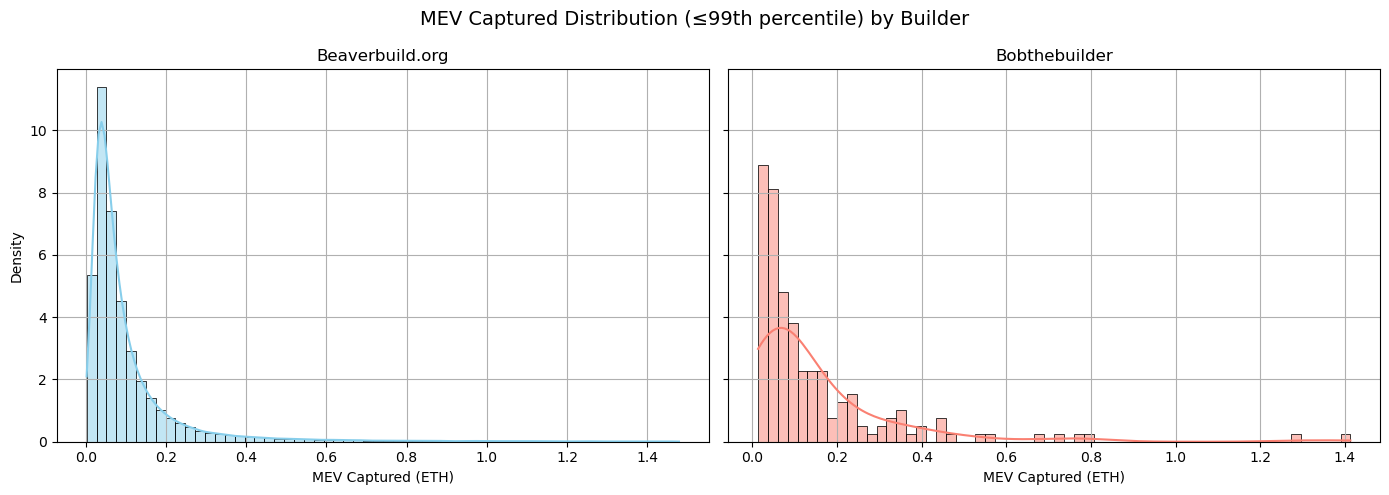

In [316]:
# Filter two builders
df_bob = df_q99[df_q99["builder_name"] == "bobthebuilder"]
df_beaver = df_q99[df_q99["builder_name"] == "beaverbuild.org"]

# Plot side-by-side histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.histplot(df_beaver["mev_captured_eth"], bins=60, stat="density", ax=axs[0], kde=True, color="skyblue")
axs[0].set_title("Beaverbuild.org")
axs[0].set_xlabel("MEV Captured (ETH)")
axs[0].grid(True)

sns.histplot(df_bob["mev_captured_eth"], bins=60, stat="density", ax=axs[1], kde=True, color="salmon")
axs[1].set_title("Bobthebuilder")
axs[1].set_xlabel("MEV Captured (ETH)")
axs[1].grid(True)

fig.suptitle("MEV Captured Distribution (≤99th percentile) by Builder", fontsize=14)
plt.tight_layout()
plt.show()

### 4.1 Beaverbuild
- Used full core data (≤ 99%), no additional trimming  
- Fitted a log-normal distribution  
- Histogram and QQ plot both showed a strong fit  

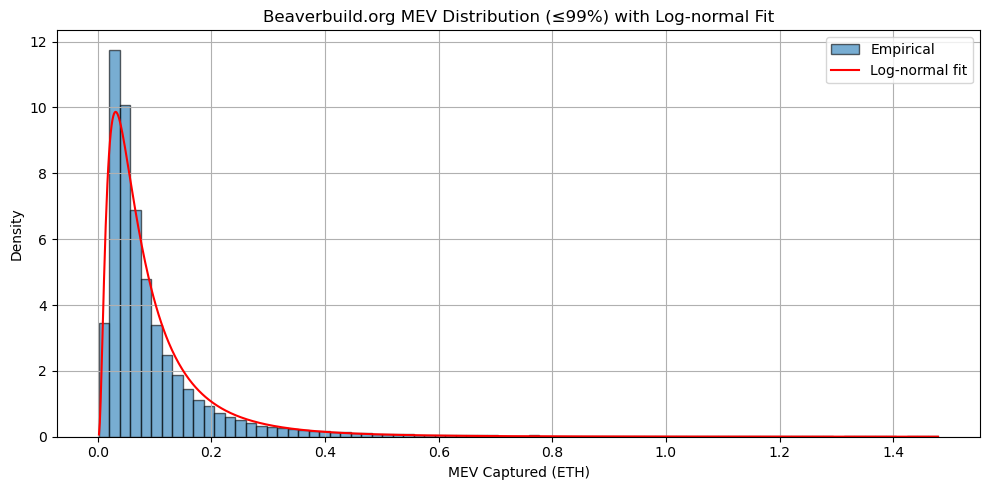

Beaverbuild.org log-normal fit:
  shape (σ)  = 0.8790
  loc        = 0.0000
  scale      = 0.0677
  mean (ETH) = 0.0996
  std  (ETH) = 0.1075


In [317]:
mev_beaver = df_beaver["mev_captured_eth"].values

# Fit log-normal distribution (loc fixed to 0 for stability)
shape, loc, scale = lognorm.fit(mev_beaver, floc=0)

# Plot histogram + fitted PDF
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(mev_beaver, bins=80, density=True, alpha=0.6, edgecolor='black', label="Empirical")

x = np.linspace(mev_beaver.min(), mev_beaver.max(), 1000)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r-', label="Log-normal fit")

plt.xlabel("MEV Captured (ETH)")
plt.ylabel("Density")
plt.title("Beaverbuild.org MEV Distribution (≤99%) with Log-normal Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute implied mean and std for interpretability
mean = lognorm.mean(shape, loc=loc, scale=scale)
std = lognorm.std(shape, loc=loc, scale=scale)

# Output key parameters and descriptive stats
print("Beaverbuild.org log-normal fit:")
print(f"  shape (σ)  = {shape:.4f}")
print(f"  loc        = {loc:.4f}")
print(f"  scale      = {scale:.4f}")
print(f"  mean (ETH) = {mean:.4f}")
print(f"  std  (ETH) = {std:.4f}")

The red log-normal curve closely follows the shape of the real data. Most MEV values fall between 0 and 0.3 ETH.

The visual fit is smooth and accurate across the whole range. The log-normal model is a good representation of Beaver's MEV distribution.

Next step will use a QQ plot, which visually compares the real MEV values to the model. If the points fall near the diagonal line, it confirms the log-normal fit is working well.

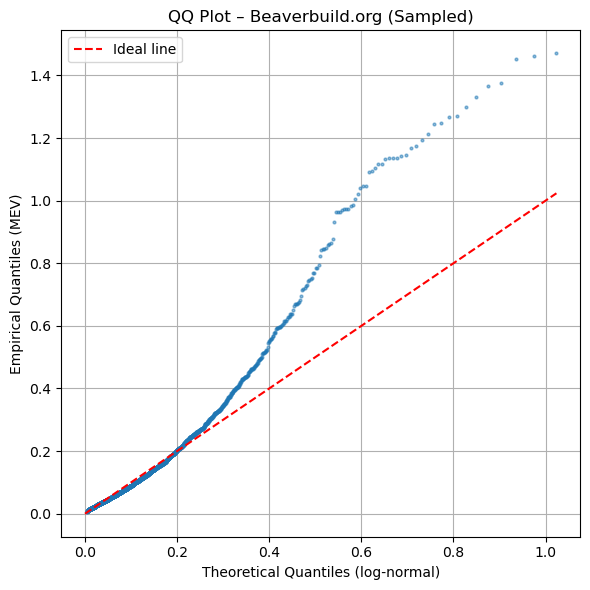

In [318]:
# Generate QQ plot for Beaverbuild.org MEV distribution
# Random subsample for QQ plot
np.random.seed(42)
sample = np.random.choice(mev_beaver, size=5000, replace=False)
sample.sort()
theoretical = lognorm.ppf(np.linspace(0.001, 0.999, len(sample)), shape, loc=loc, scale=scale)

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.plot(theoretical, sample, 'o', markersize=2, alpha=0.5)
plt.plot([0, max(theoretical)], [0, max(theoretical)], 'r--', label="Ideal line")
plt.xlabel("Theoretical Quantiles (log-normal)")
plt.ylabel("Empirical Quantiles (MEV)")
plt.title("QQ Plot – Beaverbuild.org (Sampled)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The blue dots match the red diagonal line very well up to around 0.4 ETH. After that, the dots curve above the line, meaning the real MEV values are higher than what the log-normal model expects.

We modeled the MEV captured by Beaverbuild.org using the core 99% of block data (excluding extreme outliers). A log-normal distribution was fitted, and both the histogram and QQ plot show that this model fits the data very well.

The fitted distribution has the following parameters:

shape (σ) = 0.8790

scale (exp(μ)) = 0.0677

mean = 0.0996 ETH

standard deviation = 0.1075 ETH

This means the typical MEV per block is around 0.10 ETH, with a similar amount of variability. The histogram and fitted curve align closely across the main range of the data (up to ~0.4 ETH). There is some slight underestimation in the upper tail, which is common in MEV data due to rare high-MEV blocks.

Conclusion: The log-normal model is a strong fit for Beaverbuild’s typical MEV behavior.

---

### 4.2 Bobthebuilder
- Small sample size: only 169 blocks  
- Visual inspection revealed 2 high outliers (~1.3+ ETH) → removed using 99th percentile trim  
- Fitted log-normal using bootstrap (10,000 resamples) for stability 

Bobthebuilder sample size: 169


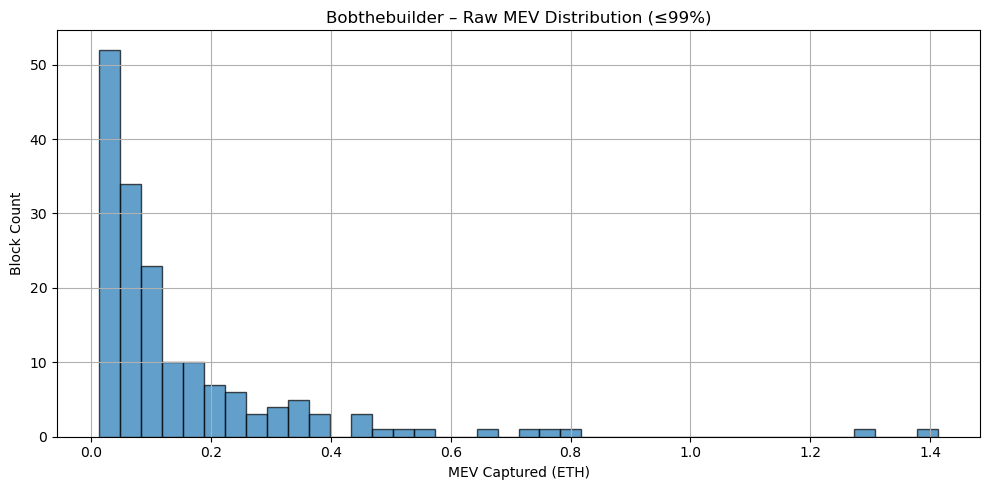

In [319]:
# Extract Bobthebuilder core MEV values
mev_bob = df_bob["mev_captured_eth"].values

# Check basic info
print("Bobthebuilder sample size:", len(mev_bob))

# Bob's raw MEV (core 99%)
plt.figure(figsize=(10, 5))
plt.hist(mev_bob, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("MEV Captured (ETH)")
plt.ylabel("Block Count")
plt.title("Bobthebuilder – Raw MEV Distribution (≤99%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [320]:
# Look at Bob's quantiles to choose cutoff
quantiles = np.percentile(mev_bob, [90, 95, 97, 98, 99, 100])
for p, q in zip([90, 95, 97, 98, 99, 100], quantiles):
    print(f"{p}th percentile: {q:.4f} ETH")

90th percentile: 0.3449 ETH
95th percentile: 0.4648 ETH
97th percentile: 0.6648 ETH
98th percentile: 0.7636 ETH
99th percentile: 0.9586 ETH
100th percentile: 1.4130 ETH


The spike clearly starts above the 99th percentile (around 0.96 ETH and up to 1.41 ETH),
so it makes the most sense to cut at the 99th percentile for fitting which removes only the two extreme values

In [321]:
# Bob's MEV trimmed to ≤ 99th percentile
cutoff = np.percentile(mev_bob, 99)
mev_bob_clean = mev_bob[mev_bob <= cutoff]

Bobthebuilder has only 169 blocks in the dataset. This is a small sample size compared to other builders like Beaverbuild.org, which has over 130,000 blocks. With such a small dataset, fitting a log-normal model just once could give misleading or unstable results. A single fit might overfit to random noise, underestimate the true variation,and depend too much on outliers or gaps in the data.

We use bootstrapping to estimate the distribution of the fitted parameters. In this case, we repeatedly sampled 169 MEV values from Bob's data, fitted a lognormal distribution for each sample, and collected shape and scale parameters from each fit.

In [322]:
# Set up storage for fitted parameters
shape_list = []
scale_list = []

n_bootstrap = 10000
np.random.seed(11)

# Bootstrap loop
for _ in range(n_bootstrap):
    sample = np.random.choice(mev_bob_clean, size=len(mev_bob_clean), replace=True)
    shape, loc, scale = lognorm.fit(sample, floc=0)
    shape_list.append(shape)
    scale_list.append(scale)


# Compute mean and 95% confidence intervals
# Convert lists to arrays
shape_arr = np.array(shape_list)
scale_arr = np.array(scale_list)

# Compute stats
shape_mean = shape_arr.mean()
shape_ci = np.percentile(shape_arr, [2.5, 97.5])

scale_mean = scale_arr.mean()
scale_ci = np.percentile(scale_arr, [2.5, 97.5])

# Print results
print("Trimmed Bob (≤99%) Bootstrap Log-normal Fit:")
print(f"  shape (σ):    Mean = {shape_mean:.4f},  95% CI = [{shape_ci[0]:.4f}, {shape_ci[1]:.4f}]")
print(f"  scale (expμ): Mean = {scale_mean:.4f},  95% CI = [{scale_ci[0]:.4f}, {scale_ci[1]:.4f}]")

# Use the same shape_mean and scale_mean from bootstrap
mean_bob = lognorm.mean(shape_mean, loc=0, scale=scale_mean)
std_bob = lognorm.std(shape_mean, loc=0, scale=scale_mean)

print(f"  Bob MEV mean (ETH): {mean_bob:.4f}")
print(f"  Bob MEV std  (ETH): {std_bob:.4f}")

Trimmed Bob (≤99%) Bootstrap Log-normal Fit:
  shape (σ):    Mean = 0.9502,  95% CI = [0.8657, 1.0338]
  scale (expμ): Mean = 0.0866,  95% CI = [0.0749, 0.0998]
  Bob MEV mean (ETH): 0.1361
  Bob MEV std  (ETH): 0.1648


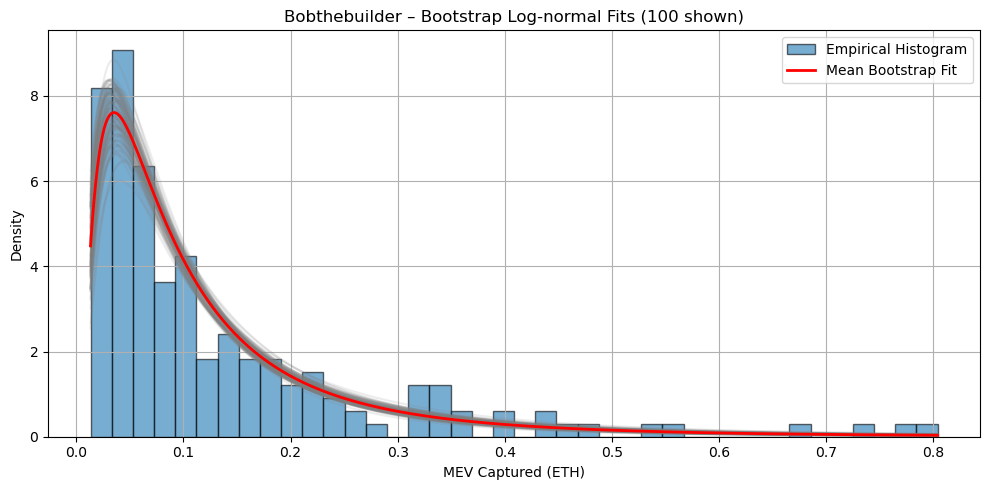

In [323]:
# Plot Bob's histogram
plt.figure(figsize=(10, 5))
plt.hist(mev_bob_clean, bins=40, density=True, alpha=0.6, edgecolor='black', label="Empirical Histogram")

# Overlay multiple bootstrap log-normal fits
x = np.linspace(mev_bob_clean.min(), mev_bob_clean.max(), 500)

# Plot 100 randomly chosen bootstrap fits for visibility
np.random.seed(3)
for i in np.random.choice(len(shape_list), size=100, replace=False):
    shape_i = shape_list[i]
    scale_i = scale_list[i]
    pdf_i = lognorm.pdf(x, shape_i, loc=0, scale=scale_i)
    plt.plot(x, pdf_i, color="gray", alpha=0.15)

# Plot the mean fit on top
pdf_mean = lognorm.pdf(x, shape_mean, loc=0, scale=scale_mean)
plt.plot(x, pdf_mean, 'r-', linewidth=2, label="Mean Bootstrap Fit")

plt.xlabel("MEV Captured (ETH)")
plt.ylabel("Density")
plt.title("Bobthebuilder – Bootstrap Log-normal Fits (100 shown)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We modeled the MEV captured by Bobthebuilder using the core 99% of block data (excluding two extreme outliers). A log-normal distribution was fitted using 10,000 bootstrap samples, and the histogram plus overlayed fit show that this model fits the data well.

The fitted distribution has the following parameters:

shape (σ) = 0.9502

scale (exp(μ)) = 0.0866

mean (ETH) = 0.1361

std  (ETH)= 0.1648


---

### 4.3. Comparing MEV Distributions: Bobthebuilder vs Beaverbuild.org

| Builder        | Mean MEV (ETH) | Std Dev (ETH) | Notes                           |
|----------------|----------------|----------------|----------------------------------|
| Beaverbuild    | 0.0996         | 0.1075         | Core data (≤99%), single fit     |
| Bobthebuilder  | 0.1361         | 0.1648         | Trimmed + bootstrap (stable fit) |

We fitted log-normal distributions to the MEV captured per block for both builders, using the core 99% of blocks in each case. For Bobthebuilder, we also removed the top 1% of values due to visible outliers and used bootstrap resampling to get stable parameter estimates.


- Bob’s average MEV per block is slightly higher than Beaver’s (0.1361 vs 0.0996 ETH),

- Bob’s standard deviation is also higher (0.1648 vs 0.1075 ETH), meaning his results are more spread out and variable,

This suggests that Bob’s MEV capture ability is more aggressive but less consistent than Beaver’s — Bob has a slightly “wider” distribution.

Conclusion: Bobthebuilder may capture more MEV on average, but with greater volatility. Beaverbuild captures slightly less but does so more steadily across many blocks.